# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Solutions to Homework #5
**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, March 2nd, 2018 at 11:00am

**Instructions:**

- Upload your final answers in a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

In [2]:
import numpy as np
import pandas as pd
from scipy import stats 
from scipy.stats import multivariate_normal
import time
import math
from functools import partial
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

## Problem 1: Optimization (contd)

Suppose you are building a pricing model for laying down telecom cables over a geographical region. Your model takes as input a pair of  coordinates, $(x, y)$, and contains two parameters, $\lambda_1, \lambda_2$. Given a coordinate, $(x, y)$, and model parameters, the loss in revenue corresponding to the price model at location $(x, y)$ is described by
$$
L(x, y, \lambda_1, \lambda_2) = 0.000045\lambda_2^2 y - 0.000098\lambda_1^2 x  + 0.003926\lambda_1 x\exp\left\{\left(y^2 - x^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
$$
Read the data contained in `HW3_data.csv`. This is a set of coordinates configured on the curve $y^2 - x^2 = -0.1$. Given the data, find parameters $\lambda_1, \lambda_2$ that minimize the net loss over the entire dataset.

### Simulated Annealing 
Implement Simulated Annealing initalized at $(\lambda_1, \lambda_2) = (-5, 0)$ to minimize our loss function $L$. Compare your results to what you obtained for gradient descent and stochastic gradient descent initialized at $(\lambda_1, \lambda_2) = (-5, 0)$.

For your Simulated Annealing implementation, we suggest *starting* with following settings for parameters (you should further experiment with and tweak these or feel free to set your own):

- Proposal distribution: bivariate normal with covariance $[[1, 0], [0, 1]]$
- Min Length: 500
- Max Temperature: 10

You should also set your own cooling schedule.

For each temperature, plot the parameters accepted or the cost function with respect to the iteration number. What is happening to the these parameters or costs over iterations? Connect the trends you observe in the visualization to the lecture on Markov Chains.

**Solutions: **


To perform simulated annealing, we just need the following ingredients:

1. an objective function, this will be our total loss function $L$
2. a proposal function, $g$ (satisfying some technical conditions)
3. a heatin/cooling schedule
4. hyperparameter settings: maximum temperature, minimum chain length at each temperature


Since our total loss function is a real-valued function in two variables ($\lambda_1$ and $\lambda_2$), we need our proposal function $g(\lambda^{new}_1, \lambda^{new}_2 | \lambda^{old}_1, \lambda^{old}_2)$ to also be a bivariate function. To keep things simple, let's choose
$$
g(\lambda^{new}_1, \lambda^{new}_2 | \lambda^{old}_1, \lambda^{old}_2) = \mathcal{N}(\lambda^{new}_1, \lambda^{new}_2; [\lambda^{old}_1, \lambda^{old}_2], \Sigma),
$$
that is, the proposal function is a normal pdf centered at the current values of lambda with covariance matrix $\Sigma$. In our case, we will set $\Sigma = \left(\begin{array}{cc} 1& 0\\ 0& 1 \end{array}\right)$

We will run the algorithm for 10 epochs, each time cooling the current temperature by 80%. At each temperature, we will let the algorithm run for 120% longer than at the previous, higher, temperature (running the algo longer at cooler temperatures will encourage convergences).

In [1]:
#Simulated Annealing
def sa(energy, init_params, epochs, reduce_temp, incr_iters, proposal):
    accumulator = []
    
    old_solution = init_params['solution']
    old_energy = energy(old_solution)
    
    temp = init_params['max_temp']
    length = init_params['min_length']
    
    accepted=0
    total=0
    
    for epoch in range(epochs):
        #print "Epoch:", epoch
        
        #decrease temperature and increase iteration length
        if epoch > 0:
            temp = reduce_temp(temp)
            length = incr_iters(length)
            
        #print "Temperature", temp, "Length", length

        for it in range(length):
            total += 1
            
            #propose new solution based on current solution
            new_solution = proposal(old_solution)
            #compute energy of new solution
            new_energy = energy(new_solution)
            
            #compute a probability for accpeting new solution
            alpha = min(1, np.exp((old_energy - new_energy) / temp))
            
            #if new solution is better, i.e. gives us lower energy, then accept
            #if new solution is not better, we flip a weighted coin and decide whether to accept
            if ((new_energy < old_energy) or (np.random.uniform() < alpha)): 
                accepted += 1
                accumulator.append([temp, new_solution, new_energy])
                
                old_energy = new_energy
                old_solution = new_solution
                
            else:
                # Keep the old stuff
                accumulator.append([temp, old_solution, old_energy])

    return accumulator, accepted * 1. / total

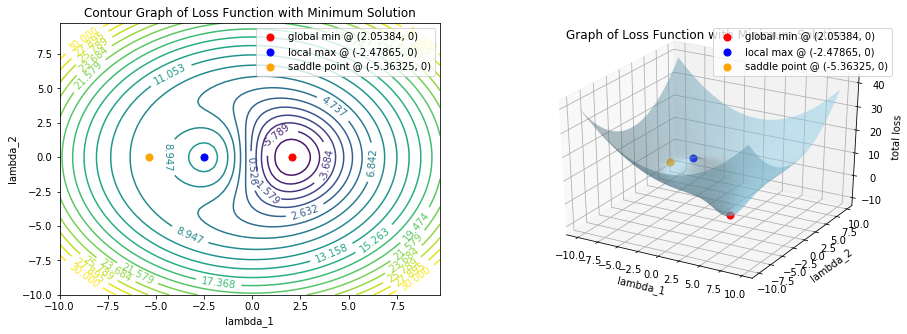

In [7]:
#Read the data
x, y = np.genfromtxt('HW3_data.csv', delimiter=',')

#Some constants we'll need
x_sum = x.sum()
y_sum = y.sum()
N = len(x)

#Total loss
L = lambda l1, l2, x, y: 0.000045 * l2**2 * y.sum() - 0.000098 * l1**2 * x.sum() + 0.003926 * x.sum() * l1 * np.exp(-0.1 * (l1**2 + l2**2))

#Cover the domain of the pdf with a grid and get the coordinates of the grid vertices
delta = 0.25
l1 = np.arange(-10, 10, delta)
l2 = np.arange(-10, 10, delta)
l1, l2 = np.meshgrid(l1, l2)
#The loss function evaluated at the vertices of the grid
loss = L(l1, l2, x, y)

fig = plt.figure(figsize=(15, 5))

#plot contour map of pdf with data in R^2 (Cartesian plane)
ax1 = fig.add_subplot(121) 
contour = ax1.contour(l1, l2, loss, levels=np.linspace(-10, 30, 20))
ax1.scatter([2.05384], [0], color='red', s=50, label='global min @ (2.05384, 0)')
ax1.scatter([-2.47865], [0], color='blue', s=50, label='local max @ (-2.47865, 0)')
ax1.scatter([-5.36325], [0], color='orange', s=50, label='saddle point @ (-5.36325, 0)')
ax1.clabel(contour, inline=1, fontsize=10)
ax1.set_title('Contour Graph of Loss Function with Minimum Solution')
ax1.set_xlabel('lambda_1')
ax1.set_ylabel('lambda_2')
ax1.legend(loc='best')

#plot 3D suface of pdf in R^3
ax2 = fig.add_subplot(122, projection='3d') 
ax2.plot_trisurf(l1.flatten(), l2.flatten(), loss.flatten(), linewidth=0.2, antialiased=True, color='skyblue', alpha=0.5, zorder=0)
ax2.scatter([2.05384], [0], [L(2.05384, 0, x, y)], color='red', s=50, label='global min @ (2.05384, 0)')
ax2.scatter([-2.47865], [0], [L(-2.47865, 0, x, y)], color='blue', s=50, label='local max @ (-2.47865, 0)')
ax2.scatter([-5.36325], [0], [L(-5.36325, 0, x, y)], color='orange', s=50, label='saddle point @ (-5.36325, 0)', zorder=10)
ax2.set_xlabel('lambda_1')
ax2.set_ylabel('lambda_2')
ax2.set_zlabel('total loss')
ax2.set_title('Graph of Loss Function with Minimum Solution')
ax2.legend(loc='best')

plt.show()

In [2]:
#Proposal distribution: bivariate normal with 
Sigma = [[1, 0], [0, 1]]
proposal = lambda x: np.random.multivariate_normal(x, Sigma, 1)[0]

reduce_temp = lambda t: 0.8*t #temperature function
incr_iters = lambda length: int(math.ceil(1.2*length)) #iteration function

energy = lambda l: L(l[0], l[1], x, y)

In [8]:
lambdas_inits = [[-2.47865, 0], [-3, 0], [-5, 0], [-10, 0]]

for lambdas in lambdas_inits:
    init_params = {'solution':np.array(lambdas), 'min_length':500, 'max_temp':10}
    accumulator, accepted_ratio = sa(energy, init_params, 10, reduce_temp, incr_iters, proposal)
    print('\n******** Results for init @ ({}, {})********'.format(lambdas[1], lambdas[0]))
    print('ratio of solutions accepted: ', accepted_ratio)
    accumulator_sorted = sorted(accumulator, key=lambda t: t[2])
    print('we found the minimum of {} with parameters ({}, {}), at temperature {}'.format(accumulator_sorted[0][2], accumulator_sorted[0][1][0], accumulator_sorted[0][1][1], accumulator_sorted[0][0]))


******** Results for init @ (0, -2.47865)********
ratio of solutions accepted:  0.5616723129042193
we found the minimum of -9.933936228983212 with parameters (2.055669934808391, -0.01117119822692414), at temperature 1.3421772800000007

******** Results for init @ (0, -3)********
ratio of solutions accepted:  0.5602864182322144
we found the minimum of -9.933000624759316 with parameters (2.04746049547048, 0.02799058709100305), at temperature 1.6777216000000008

******** Results for init @ (0, -5)********
ratio of solutions accepted:  0.5659069910686788
we found the minimum of -9.933634299206249 with parameters (2.0658309640950288, 0.00918491238599528), at temperature 1.3421772800000007

******** Results for init @ (0, -10)********
ratio of solutions accepted:  0.5582845703726517
we found the minimum of -9.933572889881697 with parameters (2.0468034127313675, 0.017827515119415632), at temperature 1.3421772800000007


In [ ]:
### Should have plots of the Energy and/or Parameters vs Temperature/Iteration

**Conclusion:** From the above we see that, with Simulated Annealing, we were able to converge around the correct global minimum for all the initial values of lambdas that caused problems for gradient descent (and for stochastic gradient descent, up to a point).  The SA annealing algorithm should at the highs temperature explore the entire parameter search space but as temperature lowers energy should minimize and parameters should converge to a global minimum.  At lower temperatures energy should drop at lower rates as the algorithm reduces to searching local optima.

## Problem 2: A Tired Salesman

In the famous traveling salesman problem, the quality of the solution can be measured in 
different ways, beyond finding the shortest path.  For example, the total time of travel may also be important, and may depend on the means of transportation that connect pairs of 
cities.  Consider a random distribution of $N$ points on a plane representing the cities 
that must be visited by the traveling salesman.  Each point is an (x,y) coordinate where both x and y are integers in the range [1, 50). Assign a value $s_i$ where $i\in [1,\dots,N]$ to each city that represents its size measured by population.  Let $\forall s_i, \  s_i \in [1, 10)$.  If two cities are farther away from each other than a **distance threshold of 10** and both have populations greater than a **population threshold of 5** assume there is a flight connection between them.  In all other cases assume that our poor salesman would have to drive between cities. Flying is faster than driving by a factor of 10. 

1. Use Simulated Annealing to find solutions to the traveling salesman problem for 
$N=100$, optimizing the travel path for the total distance travelled (but keeping track 
of the time of travel). 

2. Now redo the problem by optimizing the the path for the total time of travel (but keeping track of the distance traveled). Are the two solutions similar or different? 

3. How do your results change if the population and distance thresholds for the exisitence of a flight between two cities are altered?


**Solution**

The first thing we'll need to do is generate some infrastructure code to generate and visualize the Cities, Populations and Tours.

In [34]:
import math
import random

# Cities are represented as Points, which are a subclass of complex numbers
from collections import namedtuple

City = namedtuple('City', ['x', 'y', 'pop'], verbose=True)

def distance(A, B): 
    "The distance between two points."
    return math.sqrt((A.x - B.x)*(A.x - B.x) + (A.y - B.y)*(A.y - B.y))

def Cities(n, width=900, height=600, maxpop=10, seed=42):
    "Make a set of n cities, each with random coordinates within a (width x height) rectangle."
    random.seed(seed * n)
    return frozenset(City(random.randrange(1,width), random.randrange(1, height), random.randrange(1, maxpop))
                     for c in range(n))

def tour_length(tour):
    "The total of distances between each pair of consecutive cities in the tour."
    return sum(distance(tour[i], tour[i-1]) 
               for i in range(len(tour)))

def first(collection):
    "Start iterating over collection, and return the first element."
    return next(iter(collection))

def plot_tour(tour):
    "Plot the cities as circles and the tour as lines between them. Start city is red square."
    start = tour[0]
    plot_lines(list(tour) + [start])
    plot_lines([start], 'rs') # Mark the start city with a red square
    
def plot_roads_flights(ax, tour, dist_threshold=10, pop_threshold=5):
    "Plot the cities in a tour with flights differentiated from drives."
    
    tour = tour + [tour[0]]
    
    for i in range(len(tour) - 1, 0, -1):
        if distance(tour[i-1], tour[i]) == duration(tour[i-1], tour[i], dist_threshold=dist_threshold, pop_threshold=pop_threshold):
            plot_lines(ax, [tour[i-1], tour[i]], 'b-', pop_threshold=pop_threshold)
        else:
            plot_lines(ax, [tour[i-1], tour[i]], 'y-', pop_threshold=pop_threshold)
        
    plot_lines(ax, [tour[0]], 'rs') # Mark the start city with a red square
    
    
def plot_lines(ax, points, style='b-', pop_threshold=5):
    "Plot lines to connect a series of points."
    
    ax.plot([p.x for p in points], [p.y for p in points], style)
    cities = [p for p in points if p.pop > pop_threshold]
    towns  = [p for p in points if p.pop <= pop_threshold]
    ax.scatter([p.x for p in towns], [p.y for p in towns], color='b', marker='o',s=20)
    ax.scatter([p.x for p in cities], [p.y for p in cities], color='y', marker='o', s=20)
    ax.axis('scaled'); ax.axis('off')
    
def plot_tsp(ax, algorithm, cities, dist_threshold=10, pop_threshold=5, print_info = False):
    "Apply a TSP algorithm to cities, plot the resulting tour, and print information."
    # Find the solution and time how long it takes
    t0 = time.clock()
    tour = algorithm(cities)
    t1 = time.clock()
    assert valid_tour(tour, cities)
    
    ax.set_title("Dis. TH: {}  Pop. TH: {} \nLength: {:.2f}  Duration: {:.2f}"
                 .format(dist_threshold, pop_threshold, tour_length(tour), tour_time(tour, dist_threshold, pop_threshold)))
    plot_roads_flights(ax, tour, dist_threshold=dist_threshold, pop_threshold=pop_threshold)
    
    if print_info:
        print("{} city tour with length {:.1f} and duration {:.1f} min for {}"
              .format(len(tour), tour_length(tour), tour_time(tour), algorithm.__name__))
    
def valid_tour(tour, cities):
    "Is tour a valid tour for these cities?"
    return set(tour) == set(cities) and len(tour) == len(cities)


### Added to deal with time
def tour_time(tour, dist_threshold=10, pop_threshold=5):
    "The total time necessary travel a tour cycle"
    return sum(duration(tour[i], tour[i-1], dist_threshold, pop_threshold) 
               for i in range(len(tour)))

def duration(A, B, dist_threshold, pop_threshold):
    "The time spent traveling between two cities."
    
    dist = distance(A,B)
    
    return dist/10 if (dist  > dist_threshold and A.pop > pop_threshold and B.pop > pop_threshold) else dist
    

from builtins import property as _property, tuple as _tuple
from operator import itemgetter as _itemgetter
from collections import OrderedDict

class City(tuple):
    'City(x, y, pop)'

    __slots__ = ()

    _fields = ('x', 'y', 'pop')

    def __new__(_cls, x, y, pop):
        'Create new instance of City(x, y, pop)'
        return _tuple.__new__(_cls, (x, y, pop))

    @classmethod
    def _make(cls, iterable, new=tuple.__new__, len=len):
        'Make a new City object from a sequence or iterable'
        result = new(cls, iterable)
        if len(result) != 3:
            raise TypeError('Expected 3 arguments, got %d' % len(result))
        return result

    def _replace(_self, **kwds):
        'Return a new City object replacing specified fields with new values'
        result = _self._make(map(kwds.pop, ('x', 'y', 'pop'), _self))
        if kwds:
            raise ValueError('Got unexpected field names: %r' % list(kwds))
        return result

    def __repr__(self):
        '

In [33]:
### Some Heuristic Solutions

def nn_tsp(cities):
    """Start the tour at the first city; at each step extend the tour 
    by moving from the previous city to the nearest neighboring city, C,
    that has not yet been visited."""
    start = first(cities)
    tour = [start]
    unvisited = set(cities - {start})
    while unvisited:
        C = nearest_neighbor(tour[-1], unvisited)
        tour.append(C)
        unvisited.remove(C)
    return tour

def nearest_neighbor(A, cities):
    "Find the city in cities that is nearest to city A."
    return min(cities, key=lambda c: distance(c, A))

In [5]:

def swap_cities(input_tour, i, j):
    "Swap two cities at index i and j in a tour"
    
    # save city1
    city1 = input_tour[i]
    
    # save city2
    city2 = input_tour[j]
    
    new_tour = input_tour.copy()
    
    # swap
    new_tour[j] = city1
    new_tour[i] = city2
        
    return new_tour


def reverse_path(input_tour, i, j):
    "Reverse path two cities at index i and j in a tour"
    
    first_city, second_city = i, j
    
    if i > j:
        first_city, second_city = j, i
        
    
    new_tour = input_tour[:first_city] + input_tour[first_city: second_city][::-1] + input_tour[second_city:]
        
    return new_tour

    
def change_tour(input_tour, change_path=swap_cities):
    "Change a tour for tsp iteration"
    
    #possible_indices = range(1, len(input_tour)) why not?
    possible_indices = range(len(input_tour))
    # take two random indices to swap
    c1 = np.random.choice(possible_indices)
    c2 = np.random.choice(possible_indices)
    
    new_tour = change_path(input_tour, c1, c2)
    
    return new_tour

def permute_k_cities(input_tour, k=9):
    "Change a tour for tsp iteration by changing k cities"

    # in the case of error just return copy of the input tour
    new_tour = input_tour.copy()
    
    if k <= len(input_tour):
        
        # need indices of all the cities
        possible_indices = range(len(input_tour))
               
        # choose cities to permute
        original_cities = np.random.choice(possible_indices, size=k,replace=False)
        
        # permute the cities
        permuted_cities = np.random.permutation(original_cities)
        
        for i in range(len(original_cities)):
            new_tour[original_cities[i]] = input_tour[permuted_cities[i]]
        
    return new_tour


In [6]:
# We've constructed our own simulated annealing function for tsp but we don't
# really need to make any changes.  So we'll just comment the regular sa :-)
def sa_tsp(energyfunc, initials, epochs, tempfunc, iterfunc, proposalfunc, keep_track_funcs = None, print_messages=False):
    """
    Run simulated annealing on a tsp.
    """
    # Accumulate results in the same form as initals
    accumulator=[]
    
    # Our initial state is in initials['solution']
    best_solution = old_solution = initials['solution']
    
    # Our initial temperature is in initials['T']
    T=initials['T']
    
    # Our initial length (i.e. number of iterations per epoch)
    # is in initals['length']
    length=initials['length']
    
    # initialize the energy of our current state by running the 
    # energy function on our initial solution
    best_energy = old_energy = energyfunc(old_solution)
    
    # keep track of accepted proposals and total iterations
    accepted=0
    total=0
    
    # keep track of additional state that we may want to preserve
    # keep_track should be a list of functions to run at each iteration
    
    # extra state vector
    keep_track_state = []
    
    should_keep_track = keep_track_funcs != None
    
    if should_keep_track:
        
        # initialize state vector for all the functions we want to track
        old_track_state = keep_track_state = [track_func(old_solution) for track_func in keep_track_funcs]
                
    
    for index in range(epochs):
        #print("Epoch", index)
        
        # if we're past the first index, we need
        # to update our cooling schedule and iteration
        # schedule
        if index > 0:
            T = tempfunc(T)
            length=iterfunc(length)
            
        if index % 50 == 0 and print_messages:
            print("Temperature", T, "Length", length)
        
        # run through the iterations for each epoch
        for it in range(length):
            
            # keep track of total proposals
            total+=1
            
            # get a new proposal and calculate its energy
            new_solution = proposalfunc(old_solution)
            new_energy = energyfunc(new_solution)
            
            # track additional state
            if should_keep_track:
                new_track_state = [track_func(new_solution) for track_func in keep_track_funcs]
            
            # Use a min here as you could get a "probability" > 1
            alpha = min(1, np.exp((old_energy - new_energy)/T))
            if ((new_energy < old_energy) or (np.random.uniform() < alpha)):
                
                # Accept proposed solution
                accepted+=1.0
                if should_keep_track:
                    accumulator.append((T, new_solution, new_energy, new_track_state))
                else:
                    accumulator.append((T, new_solution, new_energy))
                
                # we have a new candidate for optimum (minimum)
                if new_energy < best_energy:
                    # Replace previous best with this one
                    best_energy = new_energy
                    best_solution = new_solution
                    best_index=total
                    best_temp=T
                    
                old_energy = new_energy
                old_solution = new_solution
                
                if should_keep_track:
                    old_track_state = new_track_state
            else:
                # Keep the old stuff
                
                if should_keep_track:
                    accumulator.append((T, old_solution, old_energy, old_track_state))
                else:
                    accumulator.append((T, old_solution, old_energy))
    
    best_meta=dict(index=best_index, temp=best_temp)
    print("frac accepted", accepted/total, "total iterations", total, 'bmeta', best_meta)
    return best_meta, best_solution, best_energy, accumulator

In [7]:
def visualize_cost(ax, cost, cost_label, title, temperatures=[], color_map=None):
    
    if temperatures and color_map:
        # convert to numpy arrays if they're not already in that form
        temperatures = np.array(temperatures)
        cost = np.array(cost)
        iterations = np.array(range(len(cost)))

        temp_min, temp_max = (np.min(temperatures), np.max(temperatures))
        unique_temperatures = np.sort(np.unique(temperatures))
        
        # plot the costs for each temperature in a different color
        for temp in unique_temperatures:
            indices = np.where(temperatures == temp)
            color_scale = (temp - temp_min) / (temp_max - temp_min)
            ax.plot(iterations[indices],cost[indices], alpha=0.6, lw=2, color=color_map(color_scale))
    
    else:
        ax.plot(range(len(cost)),cost, label=cost_label, alpha=0.6, lw=2)
        
    ax.set_xscale('log')
    ax.set_yticks([0, 500, 1000, 1500, 2000, 2500, 3000 ])
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Cost')
    ax.set_title(title)

### Question 1

We'll start by generating our cities and using simulated annealing to generate an optimal distance path for our 100 cities.  We have different options for a proposal in our Simulated Annealing code above.  After trying out "swapping" cities as in lab and shuffling/permuting cities, we settled on selecting a subset of the tour and reversing the path.  We've set duration to be such that for driving the magnitude of duration is the same as the distance but for flying it's 1/10th the size.  We could have chosen different units, but this seems to give the best comparison between distance and time.  We've chosen time units to be in minutes because it works out about right.  1 mile/minute is approximately 60 miles/hour -- a reasonable estimate of highway driving speed.

In [8]:
#mycities = Cities(100, seed=332)
mycities = Cities(100, height=49, width=49, seed=332)

In [61]:
initial_tour = list(mycities)
temp_func = lambda t: 0.98*t
change_k_tour = lambda tour: permute_k_cities(tour, k=3)
rev_tour = lambda tour: change_tour(tour, change_path=reverse_path)
length_func3 = lambda l: min(math.ceil(1.015*l), 600)
length_func = length_func3

init_length = length_func(10)

inits=dict(solution=initial_tour, length=init_length, T=100)

In [62]:
_, bs1, be1, out1 = sa_tsp(tour_length, inits, 500, temp_func, length_func, rev_tour, keep_track_funcs=[tour_time]);

frac accepted 0.06952601319426659 total iterations 226462 bmeta {'index': 99714, 'temp': 0.29724174309042745}


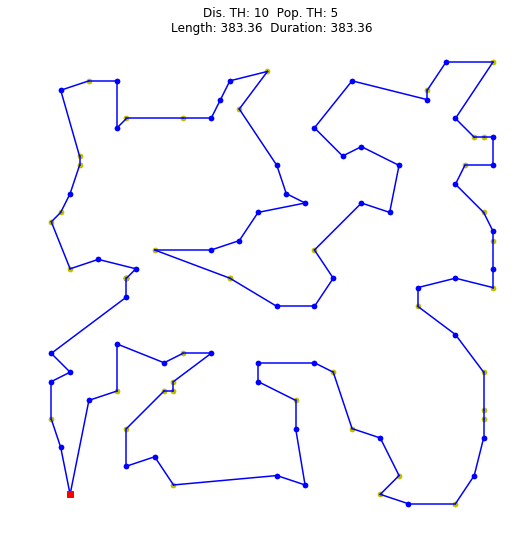

In [64]:
fig, ax = plt.subplots(figsize=(9,9))
plot_tsp(ax, lambda x: bs1, mycities)
plt.show()

The path looks pretty optimal in that the "windiness" is pretty minimal.  We're not taking any flights (and the duration being equal to the distance reflects that).  Let's compare to another approximate TSP algorithm.

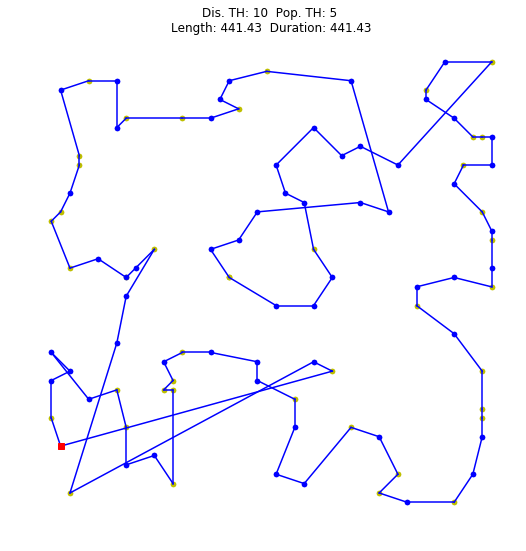

In [63]:
fig, ax = plt.subplots(figsize=(9,9))
plot_tsp(ax, nn_tsp, mycities)
plt.show()

We do quite a bit better than the nearest neighbors TSP solver which is a really good sign that our algorithm has found a good minimum.  Let's look at how distance and duration costs changed over our iterations.

In [65]:
distance_cost =  [i[2] for i in out1]
time_cost =  [i[3] for i in out1]
temperatures = [i[0] for i in out1]

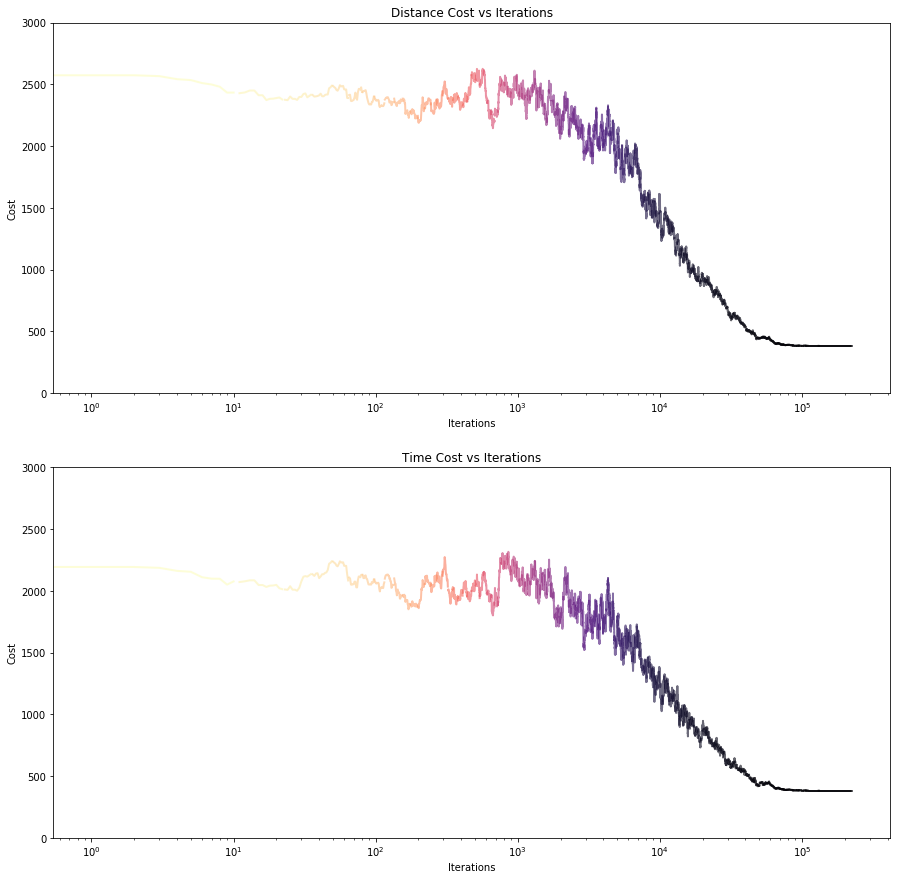

In [66]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
visualize_cost(axes[0], distance_cost, "Distance Cost", "Distance Cost vs Iterations", temperatures,plt.cm.get_cmap("magma"))
visualize_cost(axes[1], time_cost, "Time cost", "Time Cost vs Iterations", temperatures,plt.cm.get_cmap("magma"))

The two main things to note here are that the costs converge (although we could potentially run the SA for a bit longer) and that the downtrend/convergence happens during the coolest part of the temperature cycle (temperatures go from bright yellow to black).  As expected we're converging to pretty much the same value although the convergence paths aren't in lockstep.

### Question 2

We'll now run the same optimizer but for travel duration this time instead of distance.  We'll track distance as well and otherwise keep the same parameters for our SA algorithm and see what happens.

In [67]:
_, bs2, be2, out2 = sa_tsp(tour_time, inits, 500, temp_func, length_func, rev_tour, keep_track_funcs=[tour_length]);

frac accepted 0.08390370128321749 total iterations 226462 bmeta {'index': 216632, 'temp': 0.005783550865267604}


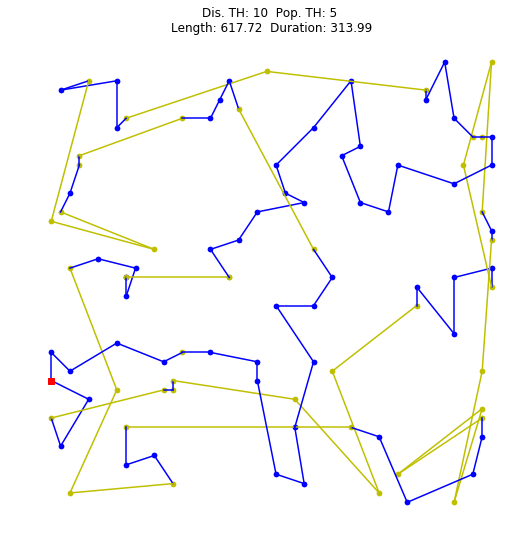

In [70]:
fig, ax = plt.subplots(figsize=(9,9))
plot_tsp(ax, lambda x: bs2, mycities)

Immediately we see that the SA algorithm for duration leads us down a much different path (pun intended) than when we optimized for distance.  The solution looks more "windy", there are a number of flights (the segments in yellow) and most important the overall duration (314.0 min) is lower than the duration we received (383.4 min) when optimizing for distance but the distance travelled is now (617.7 miles) much higher than it was (383.4 miles) when optimizing for distance travelled.  In almost all occassions, if a city can be flown in and out of (noted by the yellow dots), we take a flight. 

In [71]:
distance_cost =  [i[3] for i in out2]
time_cost =  [i[2] for i in out2]
temperatures = [i[0] for i in out2]

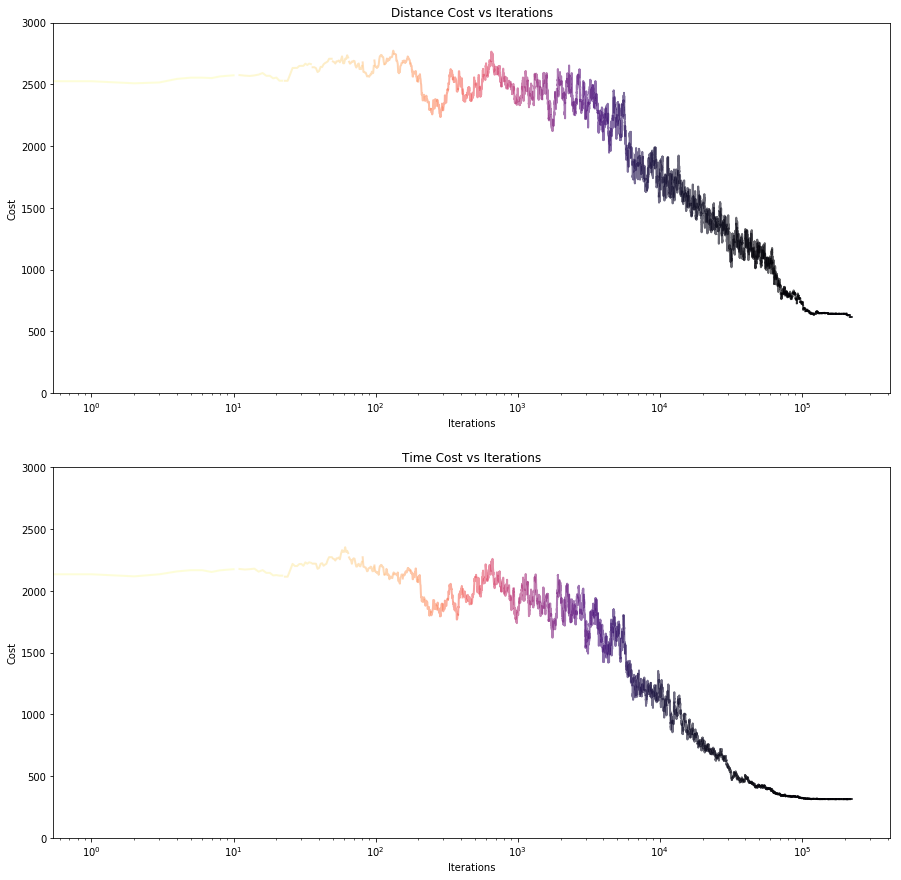

In [72]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
visualize_cost(axes[0], distance_cost, "Distance Cost", "Distance Cost vs Iterations", temperatures,plt.cm.get_cmap("magma"))
visualize_cost(axes[1], time_cost, "Time cost", "Time Cost vs Iterations", temperatures,plt.cm.get_cmap("magma"))

We see similar trends as before except that the final costs don't converge to the same value as distance costs don't converge to the same solution.

### Question 3

In order to find out the effects of different population and distance metrics on distance and time-optimized solutions we'll do the optimization for different population and distance metrics.  We should note that distance optimization won't be affected by our thresholds because our distance cost isn't affected by these thresholds.  So we'll really be reasoning about the effect of distance and time thresholds on time-optimized solutions.

Even before we run our simulations, we can just by reasoning think about a few cases.  If the population and distance threshold is really really low (e.g. 1 for population threshold and a really small distance threshold) then time-optimization should just become distance optimization because we're flying everywhere.  Similarly for distance and/or population threshold very high (e.g. 8 or 9 for population and say 70 for distance), we should now more or less be driving everywhere, so again time-optimization should be distance optimization.
 

frac accepted 0.24506098153332567 total iterations 226462 bmeta {'index': 167393, 'temp': 0.03031491484895962}
frac accepted 0.140597539543058 total iterations 226462 bmeta {'index': 186599, 'temp': 0.015881472790057822}
frac accepted 0.08296756188676246 total iterations 226462 bmeta {'index': 135654, 'temp': 0.08844521479584053}
frac accepted 0.06892105518806688 total iterations 226462 bmeta {'index': 109878, 'temp': 0.2108400381915157}
frac accepted 0.06918600030027112 total iterations 226462 bmeta {'index': 111344, 'temp': 0.19844095722554903}
frac accepted 0.24634154957564625 total iterations 226462 bmeta {'index': 200571, 'temp': 0.009979080264205688}
frac accepted 0.14038999920516465 total iterations 226462 bmeta {'index': 159104, 'temp': 0.04022455914493339}
frac accepted 0.08212856903144898 total iterations 226462 bmeta {'index': 135530, 'temp': 0.08844521479584053}
frac accepted 0.06866494157960276 total iterations 226462 bmeta {'index': 127470, 'temp': 0.11500993473146594}
fr

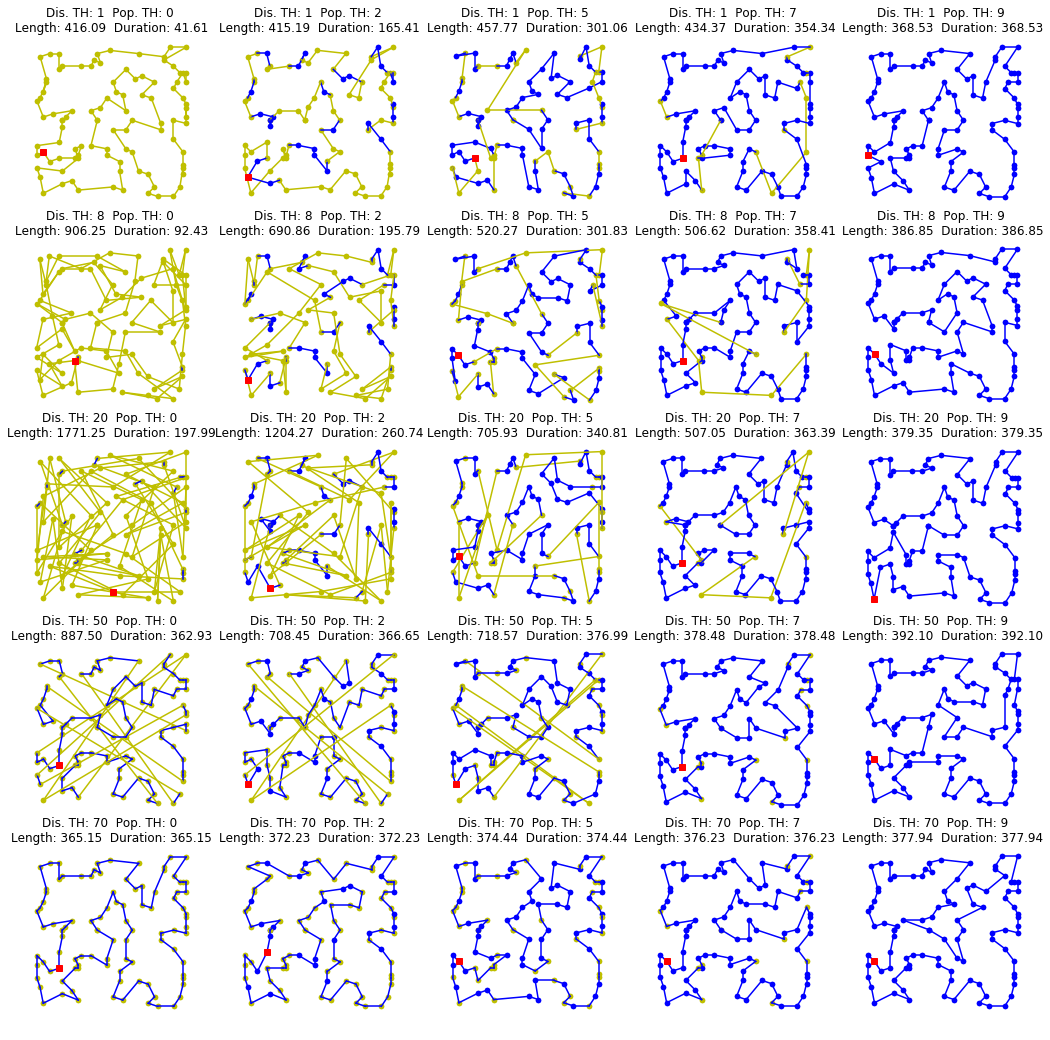

In [73]:
dist_thresholds = [1, 8, 20, 50, 70]
pop_thresholds = [0, 2, 5, 7, 9]

time_costs = np.zeros((5, 5))
dist_costs = np.zeros((5, 5))
fig, ax = plt.subplots(5, 5, figsize=(18,18))
solutions = []

for i, dist_threshold in enumerate(dist_thresholds):
    for j, pop_threshold in enumerate(pop_thresholds):
        
        duration_function = lambda x: tour_time(x, dist_threshold=dist_threshold, pop_threshold=pop_threshold)
        _, bs, be, _ = sa_tsp(duration_function, inits, 500, temp_func, length_func, rev_tour, keep_track_funcs=[tour_length]);
        plot_tsp(ax[i,j], lambda x: bs, mycities, dist_threshold=dist_threshold, pop_threshold=pop_threshold)
        
        time_costs[i,j] = be
        dist_costs[i,j] = tour_length(bs)
        solutions.append(bs)

plt.show()

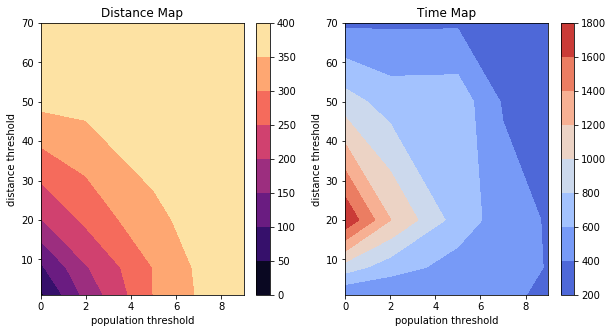

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
contour1 = ax[0].contourf(pop_thresholds, dist_thresholds, time_costs, cmap=plt.cm.get_cmap("magma"));
contour2 = ax[1].contourf(pop_thresholds, dist_thresholds, dist_costs, cmap=plt.cm.get_cmap("coolwarm"));

ax[0].set_xlabel('population threshold')
ax[0].set_ylabel('distance threshold')
ax[0].set_title('Distance Map')

ax[1].set_xlabel('population threshold')
ax[1].set_ylabel('distance threshold')
ax[1].set_title('Time Map')

fig.colorbar(contour1, ax=ax[0]);
fig.colorbar(contour2, ax=ax[1])
plt.show()

As expected we noted the following trends:

- For population and distance threshold really really low (population threshold 0 and distance threshold 1) then time-optimization just became very close to distance optimization (with distance divided by 10) because the optimal tour included flights to all cities.

- Similarly for distance and/or population threshold very high (population threshold 7 or 9 and distance threshold 70 for distance), time-optimization became distance optimization because the optimal tour involved driving everywhere.

- As the distance threshold gets higher or as the population threshold higher optimal solutions involve fewer flights and more driving and smoother paths

- Outside of the extremes we see very "windy" solutions involving many flights and a divergence between the distance travelled and duration of travel.